In [6]:
import io, os, sys, types

from sklearn import svm, neighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.externals import joblib

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Classifier

In [4]:
# %load scripts/4_pre_processing.py

# Handle the plotting
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
style.use("seaborn-deep")

# For data processing
import pandas as pd
import datetime as dt
import numpy as np
import pickle

# For getting the data
import pandas_datareader.data as web

import os
from collections import Counter

def process_data_for_labels(src, ticker, num_days):
    df = pd.read_csv(src, index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    
    for i in range(1,num_days+1):
        col_name = '{}_{}d'.format(ticker,i)
        df[col_name] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
        
    df.fillna(0, inplace=True)
    return tickers, df

def classify(*args):
    """
    return 0,1,2 so that we can construct matrices for our "labels" to allow us
    to use categorical cross entropy function
    """
    cols = [c for c in args]
    tol = 0.02
    for col in cols:
        if col > tol:
            return 0
        if col < -tol:
            return 2
    return 1

def extract_featuresets_clf(src, ticker, num_days, plot=False):
    tickers, df = process_data_for_labels(src, ticker, num_days)
    col_name = '{}_target'.format(ticker)

    df[col_name] = list(
        map(
            classify, 
            *[df['{}_{}d'.format(ticker, i)] for i in range(1, num_days+1)]
        )
    )

    # Just getting an idea of the underlying y distribution
    vals = df[col_name].values.tolist()
    str_vals = [str(i) for i in vals]
    
    if plot:
        plt.hist(df[col_name].values, bins="auto")
        plt.title('{}'.format(Counter(str_vals)))
        plt.show()
    
    # Error checking
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    
    # Creating the X values
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    X = df_vals.values
    y = df[col_name].values
    
    return X,y,df

src = 'S&P500_joined_adj-close.csv'
ticker = "AAPL"
num_days = 7

Accuracy:  0.415611814346


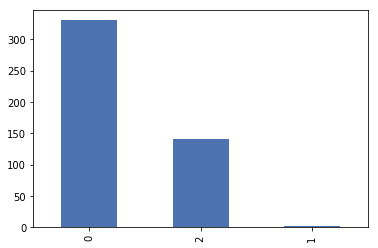

In [5]:
def train_classifier(src, ticker, num_days, voting=False):
    X, y, df = extract_featuresets_clf(src, ticker, num_days)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    if not voting:
        clf = neighbors.KNeighborsClassifier()
    else:
        clf = VotingClassifier([
            ("LSVC", svm.LinearSVC()),
            ("KNN", neighbors.KNeighborsClassifier()),
            ("R-Forest", RandomForestClassifier())])
    clf.fit(X_train, y_train)

    accuracy = clf.score(X_test, y_test)
    print("Accuracy: ", accuracy)
    
    predictions = clf.predict(X_test)
    pd.Series(predictions).value_counts().plot(kind="bar")
    plt.show()
    
train_classifier(src, ticker, num_days, voting=True)

# Regression

** Discussion ** 

1. Linear Regression: assumptions
    
    * Linear relationship - the time series is probably not linear
    
    * Multivariate normality - don't think it can be modelled by a normal distribution
    
    * No or little multicollinearity.- the data is obviously related between time instances
    
    * No auto-correlation.
    
    * Homoscedasticity.
    
    Discussion for Linear Regression is based on [statistics solutions](http://www.statisticssolutions.com/assumptions-of-linear-regression/)
    
2. ARIMA and ARMA

    Discussion to come based on [Analysis of Financial Time Series](http://faculty.chicagobooth.edu/ruey.tsay/teaching/)

In [34]:
def extract_featuresets_reg(src, ticker, num_days):
    """
    we're creating num_days new features by taking the mean across those num_days
    
    if the index of the col is less than the number of days we just put the value there
    """
    df = pd.read_csv(src, index_col=0)[ticker].to_frame()
    df.fillna(0, inplace=True)
    data = df.values
    for i in range(1, num_days+1):
        col_name = "{0}_{1}d".format(ticker, i)
        df[col_name] = [ np.mean(data[j: j+i]) if j > i else data[j][0] for j in range(len(data)) ]
        
    # We want to keep this as similar to clf interface as possible.
    # No sense overcomplicating things
    return None, None, df
    

def train_regression(src, ticker, num_days):
    """
    The plan here is to use a bunch of regression models to predict
    the change in price.
    
    Discussion of models to be used provided above

    """
    
    _, _, df = extract_featuresets_reg(src, ticker, num_days)
    
    

num_days = 7
train_regression(src, ticker, num_days)

                  AAPL     AAPL_1d     AAPL_2d     AAPL_3d     AAPL_4d  \
Date                                                                     
2010-01-04   27.505054   27.505054   27.505054   27.505054   27.505054   
2010-01-05   27.552608   27.552608   27.552608   27.552608   27.552608   
2010-01-06   27.114347   27.114347   27.114347   27.114347   27.114347   
2010-01-07   27.064222   27.064222   27.154189   27.064222   27.064222   
2010-01-08   27.244156   27.244156   27.123988   26.981542   27.244156   
2010-01-11   27.003820   27.003820   26.850235   26.924564   26.922528   
2010-01-12   26.696650   26.696650   26.884936   26.895431   26.788222   
2010-01-13   27.073221   27.073221   26.994822   26.818746   27.023417   
2010-01-14   26.916422   26.916422   26.691508   27.006816   27.058119   
2010-01-15   26.466595   26.466595   27.052013   27.105351   27.014421   
2010-01-19   27.637430   27.637430   27.424729   27.197030   26.751593   
2010-01-20   27.212029   27.212029   2